In [28]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import xarray as xr
import dask
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
from keras.layers import BatchNormalization
import tensorflow_probability as tfp
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
import xarray
import haiku as hk
import jax 
from jax import numpy as jnp
from jax import value_and_grad
from sklearn import datasets
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score


In [29]:
cd ../../icme-xplore-bayes-spring22/src/data

[Errno 2] No such file or directory: '../../icme-xplore-bayes-spring22/src/data'
/home/misbah/Desktop/CS 229/Project/icme-xplore-bayes-spring22/src/data


In [39]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks=1)
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']

In [40]:
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks=1)
Y_obs = dataset_obs['SWCF']
Y_scalar=np.sqrt(Y_obs.values.var())
Y_shift=Y_obs.values.mean()
Y_np = (Y_obs.values-Y_shift)/Y_scalar
Y_np = np.array([Yi.flatten() for Yi in Y_np])

In [41]:
X_np = X.values
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))
X=X_s.copy()

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


In [42]:
Y=(Y.values-Y_shift)/Y_scalar

KeyboardInterrupt: 

-44.000553

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=123)

X_train, X_test, Y_train, Y_test = jnp.array(X_train, dtype=jnp.float32),\
                                   jnp.array(X_test, dtype=jnp.float32),\
                                   jnp.array(Y_train, dtype=jnp.float32),\
                                   jnp.array(Y_test, dtype=jnp.float32),\

samples, features = X_train.shape

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((200, 5), (50, 5), (200, 1152), (50, 1152))

In [51]:
#     def PreprocessData(self,X,Y):
#         self.X_shifted=X.mean()
#         self.X_std=X.std()
#         X=(X-X.mean())/(X.std())
#         self.Y_shifted=Y.values.mean()
#         self.Y_std=Y.values.std()
#         Y=(Y-Y_shifted)/(Y_std)
#         X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=123)
#         X_train, X_test, Y_train, Y_test = jnp.array(X_train, dtype=jnp.float32),\
#                                            jnp.array(X_test, dtype=jnp.float32),\
#                                            jnp.array(Y_train, dtype=jnp.float32),\
#                                            jnp.array(Y_test, dtype=jnp.float32)
#         return X_train, X_test, Y_train, Y_test

In [52]:
BaseEstimator=sklearn.base.BaseEstimator

In [60]:
class HaikuNeuralNetwork(BaseEstimator):
    def __init__(self,output_sizes=[5,80,60,60,16],learning_rate=jnp.array(0.001)):
        self.output_sizes=output_sizes
        self.rng=jax.random.PRNGKey(37)
        self.learning_rate=learning_rate
        self.model=None
        self.params=None
        self.pca = PCA(n_components=output_sizes[-1],whiten=True)

    def FeedForward(self,x):
        mlp=hk.nets.MLP(output_sizes=[5,80,60,60,16],activation=jax.nn.leaky_relu)
        return mlp(x) 
    def MeanSquaredErrorLoss(self,weights, input_data, actual):
        preds=self.model.apply(weights,self.rng,input_data) ## predictions
        preds=preds.squeeze() ## flattend
        mse=jnp.power(actual-preds,2).mean() ## MSE Difference
        return mse
    def UpdateWeights(self,weights, gradients):
        return weights - self.learning_rate* gradients ### Using SGD as optimizer

    def fit(self,X,Y,epochs=1000):
        ##pca = PCA(n_components=16,whiten=True)
        Y = self.pca.fit_transform(Y)
        self.model= hk.transform(self.FeedForward)
        self.params = self.model.init(self.rng, X[:5])
        batch_size=32
        for i in range(1, epochs+1):
            batches = jnp.arange((X_train.shape[0]//batch_size)+1) ### Batch Indices
            losses = [] ## Record loss of each batch
            for batch in batches:
                if batch != batches[-1]:
                    start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
                else:
                    start, end = int(batch*batch_size), None

                X_batch, Y_batch = X[start:end], Y[start:end] ## Single batch of data

                loss, param_grads = value_and_grad(self.MeanSquaredErrorLoss)(self.params, X_batch, Y_batch)
                self.params = jax.tree_map(self.UpdateWeights, self.params, param_grads) ## Update Params
                losses.append(loss) ## Record Loss
            if i%100 == 0:
                print(i,"epoch")
                print("MSE : {:.5f}".format(jnp.array(losses).mean()))
        return self.model,self.params
    def predict(self,X):
        '''
        model.predict(X)
        '''
        pca_preds=self.model.apply(self.params, self.rng, X)
        prediction= self.pca.inverse_transform(pca_preds)
        return prediction
    def evaluate_mse(self,X,Y):
        pca_preds=self.model.apply(self.params, self.rng, X)
        Y_prediction= self.pca.inverse_transform(pca_preds)
        Mse=np.mean(np.square(Y-Y_prediction))
        return Mse

    def get_parameters(self):
        return self.params

In [61]:
print(X_train.shape,Y_train.shape)

(200, 5) (200, 1152)


In [62]:
first_haiku=HaikuNeuralNetwork()


In [63]:
model=first_haiku.fit(X_train,Y_train,1000)

100 epoch
MSE : 0.95124
200 epoch
MSE : 0.94143
300 epoch
MSE : 0.93334
400 epoch
MSE : 0.92607
500 epoch
MSE : 0.91922
600 epoch
MSE : 0.91258
700 epoch
MSE : 0.90605
800 epoch
MSE : 0.89950
900 epoch
MSE : 0.89284
1000 epoch
MSE : 0.88608


In [76]:
pred_test=first_haiku.predict(X_test)

In [77]:
first_haiku.evaluate_mse(X_test,Y_test)

0.02240699

In [78]:
pred_test_orig=pred_test*Y_std+Y_shift
Y_test_orig=Y_test*Y_std+Y_shift

In [79]:
shifted_back_mse=np.mean(np.square(pred_test_orig-Y_test_orig))

In [80]:
shifted_back_mse

36.164017

In [81]:
##cv_scores = cross_val_score(first_haiku,X,Y,scoring='neg_mean_squared_error',cv=3)

In [82]:
def plot(Y_pred,Y_test,i=0):
    lat = dataset['lat'].values
    lon = dataset['lon'].values
    Y_plot=np.reshape(Y_pred[i],(24,48))
    y_pred_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_pred",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_pred_xr)
    Y_plot=np.reshape(Y_test[i],(24,48))
    y_obs_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_actual",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_obs_xr)
    sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default_diff",
    title="Y_pred-Y_test",
    rhs_title=r"$W/m^2$",
    lhs_title="",
    )
    sample_plot.show((y_pred_xr-y_obs_xr))

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

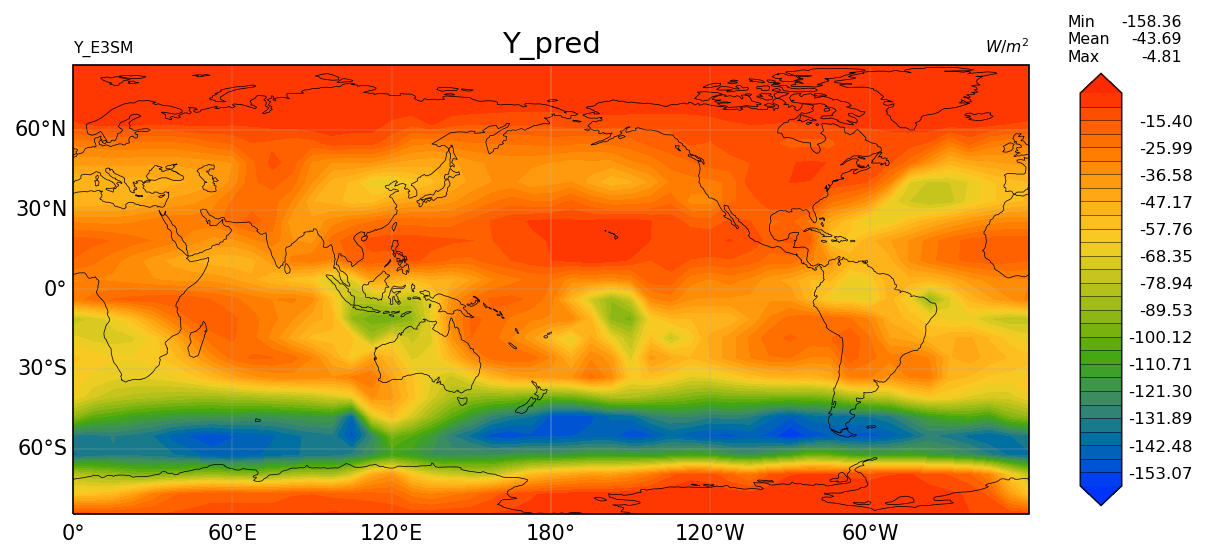

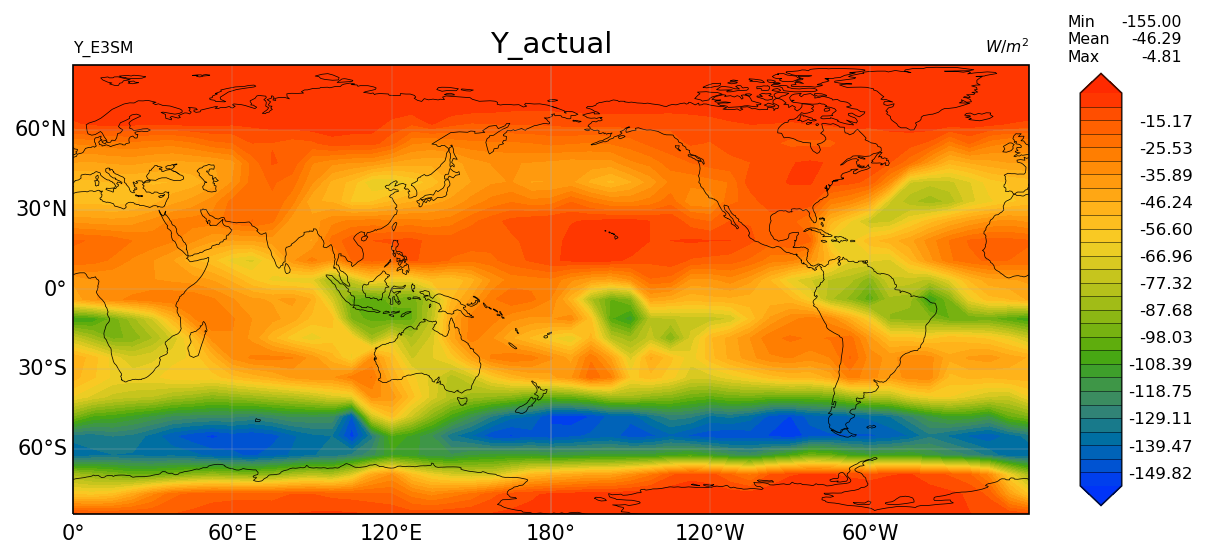

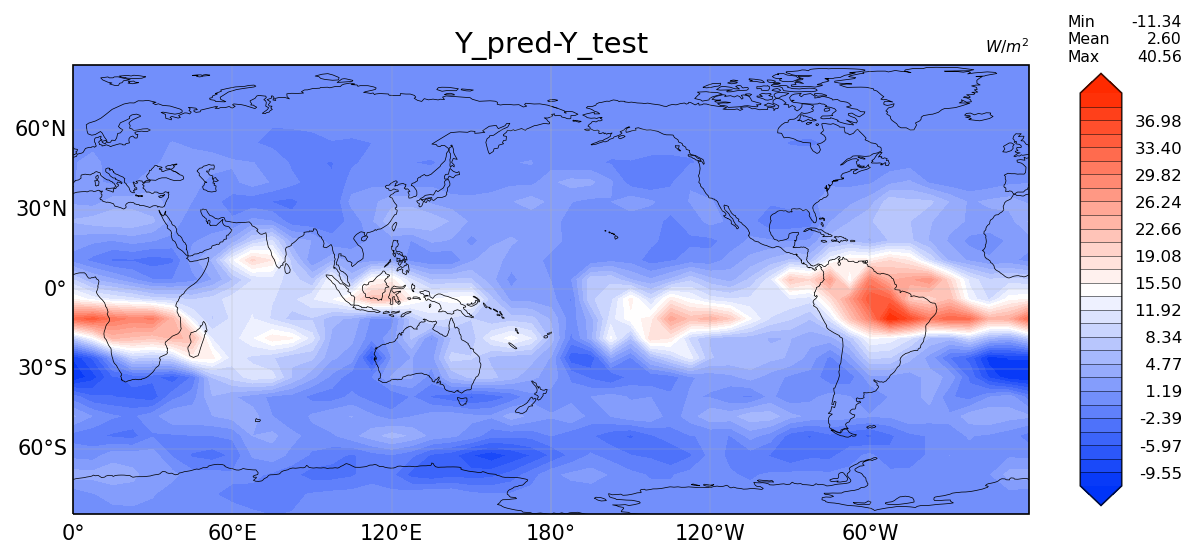

In [83]:
plot(pred_test_orig,Y_test_orig)

## TesnorFlow Version

In [90]:
import tensorflow as tf
import tensorflow.keras.backend as kb
from tensorflow import keras
def custom_loss(y_actual,y_pred):
    custom_loss=kb.square(y_actual-y_pred)
    return custom_loss
X_train=np.array(X_train)
pca=first_haiku.pca
Y_train=np.array(pca.fit_transform(Y_train))

In [91]:
model = keras.Sequential(
    [
        tf.keras.layers.Dense(5, activation="LeakyReLU", name="layer1"),
        tf.keras.layers.Dense(80, activation="LeakyReLU", name="layer2"),
        tf.keras.layers.Dense(60,activation="LeakyReLU", name="layer3"),
        tf.keras.layers.Dense(60,activation="LeakyReLU", name="layer4"),
        tf.keras.layers.Dense(16, activation="LeakyReLU",name="layer5"),
    ]
)
model.compile(optimizer=tf.optimizers.Adam(),loss=custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])

In [92]:
history=model.fit(X_train,Y_train,epochs=1000)

Epoch 1/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.9967 - root_mean_squared_error: 0.9983
Epoch 2/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.9760 - root_mean_squared_error: 0.9879
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.9605 - root_mean_squared_error: 0.9801
Epoch 4/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.9461 - root_mean_squared_error: 0.9727
Epoch 5/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.9305 - root_mean_squared_error: 0.9646
Epoch 6/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.9172 - root_mean_squared_error: 0.9577
Epoch 7/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.9046 - root_mean_squared_error: 0.9511
Epoch 8/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.8904 - root_mean_squared_error: 0.9436
Epoch 9/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.8777 - root_mean_squa

7/7 [==============================] - 0s 6ms/step - loss: 0.4798 - root_mean_squared_error: 0.6927
Epoch 144/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4800 - root_mean_squared_error: 0.6928
Epoch 145/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4803 - root_mean_squared_error: 0.6930
Epoch 146/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4773 - root_mean_squared_error: 0.6909
Epoch 147/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4762 - root_mean_squared_error: 0.6901
Epoch 148/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4760 - root_mean_squared_error: 0.6899
Epoch 149/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4729 - root_mean_squared_error: 0.6877
Epoch 150/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4697 - root_mean_squared_error: 0.6853
Epoch 151/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4704 - root_mean_sq

7/7 [==============================] - 0s 6ms/step - loss: 0.3500 - root_mean_squared_error: 0.5916
Epoch 286/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3503 - root_mean_squared_error: 0.5919
Epoch 287/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3499 - root_mean_squared_error: 0.5915
Epoch 288/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3490 - root_mean_squared_error: 0.5908
Epoch 289/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3480 - root_mean_squared_error: 0.5899
Epoch 290/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3511 - root_mean_squared_error: 0.5925
Epoch 291/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3508 - root_mean_squared_error: 0.5923
Epoch 292/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3484 - root_mean_squared_error: 0.5903
Epoch 293/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3486 - root_mean_sq

7/7 [==============================] - 0s 6ms/step - loss: 0.2800 - root_mean_squared_error: 0.5291
Epoch 428/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2813 - root_mean_squared_error: 0.5304
Epoch 429/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2791 - root_mean_squared_error: 0.5283
Epoch 430/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2797 - root_mean_squared_error: 0.5288
Epoch 431/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2804 - root_mean_squared_error: 0.5296
Epoch 432/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2800 - root_mean_squared_error: 0.5291
Epoch 433/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2782 - root_mean_squared_error: 0.5274
Epoch 434/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2764 - root_mean_squared_error: 0.5257
Epoch 435/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2771 - root_mean_sq

7/7 [==============================] - 0s 6ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855
Epoch 570/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2361 - root_mean_squared_error: 0.4859
Epoch 571/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2330 - root_mean_squared_error: 0.4827
Epoch 572/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829
Epoch 573/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2335 - root_mean_squared_error: 0.4833
Epoch 574/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2343 - root_mean_squared_error: 0.4841
Epoch 575/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2354 - root_mean_squared_error: 0.4852
Epoch 576/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2325 - root_mean_squared_error: 0.4822
Epoch 577/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2335 - root_mean_sq

7/7 [==============================] - 0s 6ms/step - loss: 0.2006 - root_mean_squared_error: 0.4478
Epoch 712/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2012 - root_mean_squared_error: 0.4485
Epoch 713/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454
Epoch 714/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1996 - root_mean_squared_error: 0.4468
Epoch 715/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2019 - root_mean_squared_error: 0.4493
Epoch 716/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1988 - root_mean_squared_error: 0.4459
Epoch 717/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1986 - root_mean_squared_error: 0.4457
Epoch 718/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2009 - root_mean_squared_error: 0.4482
Epoch 719/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1997 - root_mean_sq

7/7 [==============================] - 0s 6ms/step - loss: 0.1733 - root_mean_squared_error: 0.4163
Epoch 854/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1732 - root_mean_squared_error: 0.4161
Epoch 855/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1758 - root_mean_squared_error: 0.4193
Epoch 856/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1742 - root_mean_squared_error: 0.4174
Epoch 857/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1728 - root_mean_squared_error: 0.4158
Epoch 858/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1720 - root_mean_squared_error: 0.4148
Epoch 859/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1715 - root_mean_squared_error: 0.4141
Epoch 860/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1718 - root_mean_squared_error: 0.4144
Epoch 861/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1696 - root_mean_sq

7/7 [==============================] - 0s 6ms/step - loss: 0.1567 - root_mean_squared_error: 0.3959
Epoch 996/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1540 - root_mean_squared_error: 0.3925
Epoch 997/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1554 - root_mean_squared_error: 0.3942
Epoch 998/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1522 - root_mean_squared_error: 0.3902
Epoch 999/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1538 - root_mean_squared_error: 0.3922
Epoch 1000/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.1560 - root_mean_squared_error: 0.3949


In [93]:
test_pred_keras=model.predict(np.array(X_test))
test_preds_1152= pca.inverse_transform(test_pred_keras)

In [94]:
pred_test_orig=test_preds_1152*Y_std+Y_shift

In [95]:
Mse_test=np.mean(np.square(Y_test-test_preds_1152))

In [96]:
Mse_test

0.004789899

In [99]:
Mse_test_orig=np.mean(np.square(Y_test_orig-pred_test_orig))

In [100]:
Mse_test_orig

7.730713

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

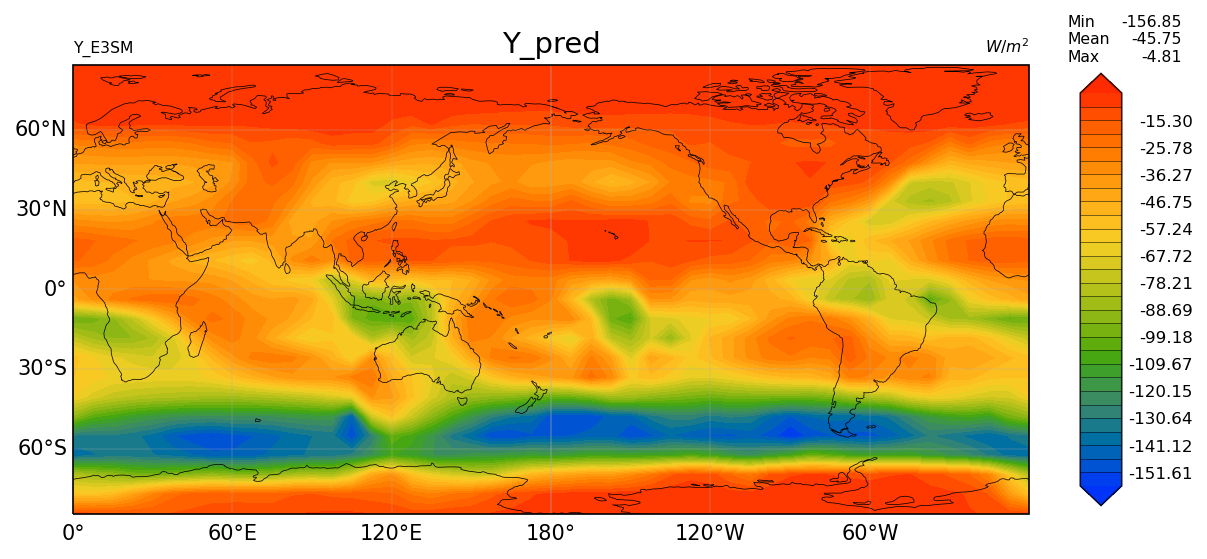

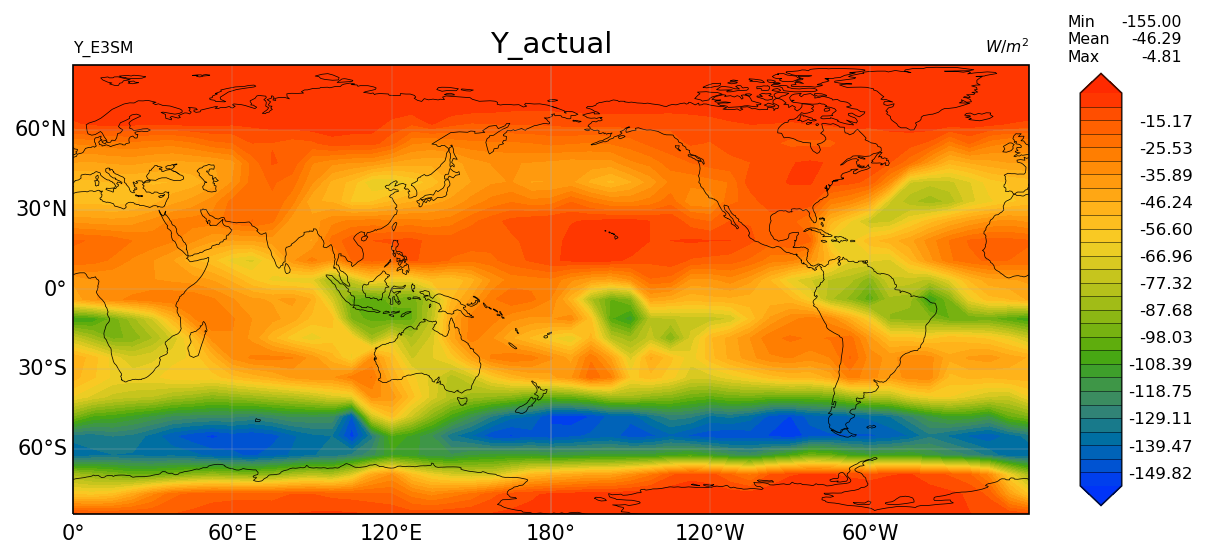

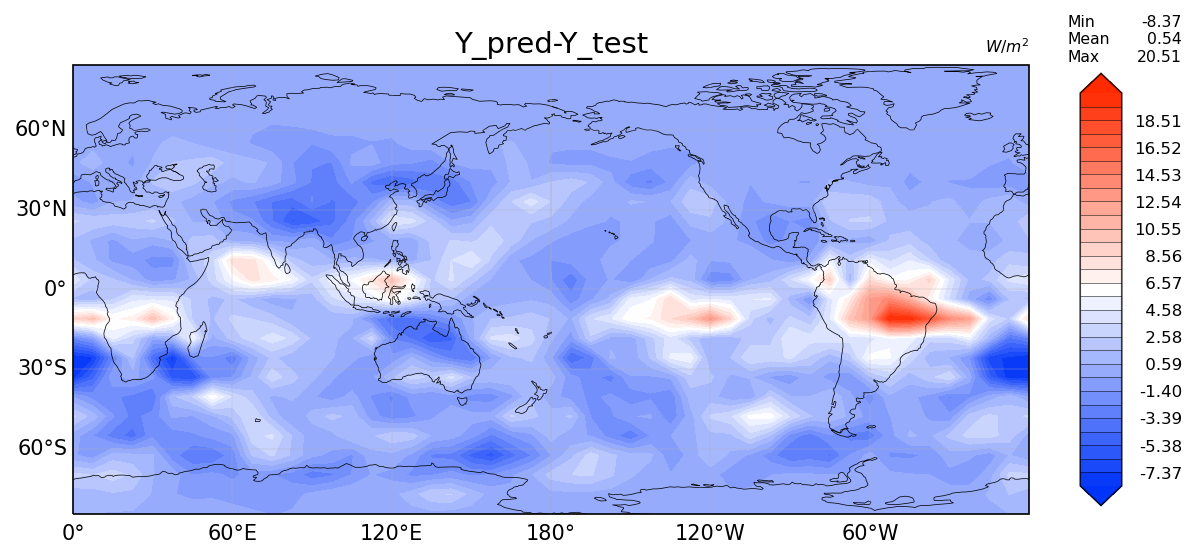

In [101]:
plot(pred_test_orig,Y_test_orig)

## Bayesian Callibration

In [21]:
from scipy import stats

In [22]:
def get_posterior(x_obs,Y_obs,model,params,mean,sigma):
    ### Bayesian model
    x_obs=np.zeros(5)
    mean=np.zeros(1152)
    sigma=np.ones(1152)
    likelihood=stats.multivariate_normal(mean,sigma)
    Y_pred_pca=model.apply(params, rng, x_obs)
    Y_pred=pca.inverse_transform(Y_pred_pca) ## y prediction 
    diff=(Y_obs.flatten()-Y_pred)
    likelihood_pdf=likelihood.pdf(diff)
    likelihod_log=likelihood.logpdf(diff)
    print(likelihod_log)
    prior=stats.uniform(-1,2)
    prior_pdf=prior.logpdf(x_obs)
    posterior=sum(prior.logpdf(x_obs))+likelihod_log
    print(posterior)

In [29]:
from scipy import stats
### Bayesian model
x_obs=np.zeros(5)
mean=np.zeros(1152)
sigma=np.ones(1152)
likelihood=stats.multivariate_normal(mean,sigma)
Y_pred_pca=model[0].apply(model[1], first_haiku.rng, x_obs)
Y_pred=first_haiku.pca.inverse_transform(Y_pred_pca) ## y prediction 
diff=(Y_obs.flatten()-Y_pred)
likelihood_pdf=likelihood.pdf(diff)
likelihod_log=likelihood.logpdf(diff)
print(likelihod_log)
prior=stats.uniform(-1,2)
prior_pdf=prior.logpdf(x_obs)
posterior=sum(prior.logpdf(x_obs))+likelihod_log
print(posterior)

-1097.7411581667152
-1101.2068940695149
